## Configuration

In [1]:
current_month = 87
house_id = 207
tsm_realm_file = 'tsm_shattrath.csv'
tsm_region_file = 'tsm_EU.csv'

reduction_strategy = 'B' # 'A','B'
k_quantity = 0.1 # k=10
k_worth = 0.05 # k=5
k_sold  = 0.05 # k=5

## Imports and data structures

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
import pymysql

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

%matplotlib inline

In [3]:
item_classes = {
    0: 'Consumable', 1: 'Container', 2: 'Weapon', 3: 'Gem', 4: 'Armor', 7: 'Tradeskill', 8: 'Item Enhancement', 9: 'Recipe', 12: 'Quest',  15: 'Miscellaneous', 16: 'Glyph', 17: 'Battle Pets', 18: 'WoW Token', 
}
item_sub_classes = {
    0: { 0: 'Explosives and Devices', 1: 'Potion', 2: 'Elixir', 3: 'Flask', 4: 'Scroll (OBSOLETE)', 5: 'Food & Drink', 6: 'Item Enhancement (OBSOLETE)', 7: 'Bandage', 8: 'Other', 9: 'Vantus Runes', },
    1: { 0:  'Bag', 1:  'Soul Bag Classic', 2:  'Herb Bag', 3:  'Enchanting Bag', 4:  'Engineering Bag', 5:  'Gem Bag', 6:  'Mining Bag', 7:  'Leatherworking Bag', 8:  'Inscription Bag', 9:  'Tackle Box', 10: 'Cooking Bag', },
    2: { 0: 'One-Handed Axes', 1: 'Two-Handed Axes', 2: 'Bows', 3: 'Guns', 4: 'One-Handed Maces', 5: 'Two-Handed Maces', 6: 'Polearms', 7: 'One-Handed Swords', 8: 'Two-Handed Swords', 9: 'Warglaives', 10: 'Staves', 11: 'Bear Claws', 12: 'CatClaws', 13: 'Fist Weapons', 14: 'Miscellaneous', 15: 'Daggers', 16: 'Thrown	Classic', 17: 'Spears', 18: 'Crossbows', 19: 'Wands', 20: 'Fishing Poles', },
    3: { 0: 'Intellect', 1: 'Agility', 2: 'Strength', 3: 'Stamina', 4: 'Spirit', 5: 'Critical Strike', 6: 'Mastery', 7: 'Haste', 8: 'Versatility', 9: 'Other', 10: 'Multiple Stats', 11: 'Artifact Relic', },
    4: { 0: 'Miscellaneous Includes Spellstones, Firestones, Trinkets, Rings and Neck', 1: 'Cloth', 2: 'Leather', 3: 'Mail', 4: 'Plate', 5: 'Cosmetic', 6: 'Shields', 7: 'Librams Classic',  8: 'Idols Classic', 9: 'Totems Classic', 10: 'Sigils Classic', 11: 'Relic', },
    5: { 0: 'Reagent', 1: 'Keystone', 2: 'Context Token', },
    6: { 0: 'Wand(OBSOLETE)', 1: 'Bolt(OBSOLETE)', 2: 'Arrow', 3: 'Bullet', 4: 'Thrown(OBSOLETE)', },
    7: { 0: 'Trade Goods (OBSOLETE)', 1: 'Parts', 2: 'Explosives (OBSOLETE)', 3: 'Devices (OBSOLETE)', 4: 'Jewelcrafting', 5: 'Cloth', 6: 'Leather', 7: 'Metal & Stone', 8: 'Cooking', 9: 'Herb', 10: 'Elemental', 11: 'Other', 12: 'Enchanting', 13: 'Materials (OBSOLETE)', 14: 'Item Enchantment (OBSOLETE)', 15: 'Weapon Enchantment - Obsolete', 16: 'Inscription', 17: 'Explosives and Devices (OBSOLETE)', },
    8: { 0: 'Head', 1: 'Neck', 2: 'Shoulder', 3: 'Cloak', 4: 'Chest', 5: 'Wrist', 6: 'Hands', 7: 'Waist', 8: 'Legs', 9: 'Feet', 10: 'Finger', 11: 'One-handed weapon', 12: 'Two-Handed Weapon', 13: 'Shield/Off-hand', 14: 'Misc', },
    9: { 0: 'Book', 1: 'Leatherworking', 2: 'Tailoring', 3: 'Engineering', 4: 'Blacksmithing', 5: 'Cooking', 6: 'Alchemy', 7: 'First Aid', 8: 'Enchanting', 9: 'Fishing', 10: 'Jewelcrafting', 11: 'Inscription', },
    10: { 0: 'Money(OBSOLETE)', },
    11: { 0: 'Quiver(OBSOLETE)', 1: 'Bolt(OBSOLETE)', 2: 'Quiver', 3: 'Ammo Pouch', },
    12: { 0: 'Quest', },
    13: { 0: 'Key', 1: 'Lockpick', },
    14: { 9: 'Permanent(OBSOLETE)', },
    15: { 0: 'Junk', 1: 'Reagent Mainly spell reagents. For crafting reagents see 7: Tradeskill', 2: 'Companion Pets', 3: 'Holiday', 4: 'Other', 5: 'Mount', 6: 'Mount Equipment', },
    16: { 1: 'Warrior', 2: 'Paladin', 3: 'Hunter', 4: 'Rogue', 5: 'Priest', 6: 'Death Knight', 7: 'Shaman', 8: 'Mage', 9: 'Warlock', 10: 'Monk', 11: 'Druid', 12: 'Demon Hunter', },
    17: { 0: 'Humanoid', 1: 'Dragonkin', 2: 'Flying', 3: 'Undead', 4: 'Critter', 5: 'Magic', 6: 'Elemental', 7: 'Beast', 8: 'Aquatic', 9: 'Mechanical', },
    18: { 0: 'WoW Token', },
}

In [4]:
def quantile_function(df, threshold, col_name):
    qnt = df.quantile(threshold)[col_name]
    return df[df[col_name] >= qnt]

## Configure Plot size

In [5]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## The Undermine Journal Market DataFrame

In [6]:
dbhost = 'newswire.theunderminejournal.com'
dbuser = ''
dbpass = ''
dbname = 'newsstand'

In [7]:
engine = create_engine('mysql+pymysql://%s:%s@%s/%s' % (dbuser,dbpass,dbhost,dbname), pool_recycle=3600)
conn = engine.connect()

In [8]:
query_realm = '''
SELECT
    t1.house as RealmId,
    t1.item as ItemId,
    t1.level as Level,
    (t1.price / 10000) as TujMarketValue,
    t1.quantity Quantity,
    t1.lastseen LastSeen,
    
    t2.name_enus Name,
    t2.class as ItemTypeId,
    t2.subclass as SubClassId,
    (t2.buyfromvendor / 10000) as VendorBuy,
    (t2.selltovendor / 10000) as VendorSell,
    
    (t3.median / 10000) as RegionMedian,
    (t3.mean / 10000) as RegionMean,
    (t3.stddev / 10000) as RegionStddev
FROM `tblItemSummary` AS t1
JOIN tblDBCItem as t2 on t2.id = t1.item
JOIN tblItemGlobal as t3 on t3.item = t1.item AND t3.level = t1.level AND t3.region = 'EU'
WHERE t1.house = %d
ORDER BY `t1`.`item` ASC
'''% (house_id)

In [9]:
tuj_df = pd.read_sql(query_realm, conn)

In [10]:
tuj_region_df = pd.read_sql('''
SELECT
    tblItemSummary.item as ItemId,
    tblItemSummary.level as Level,
    SUM(quantity) as RegionQuantity
FROM
    tblItemSummary
JOIN tblRealm ON tblItemSummary.house = tblRealm.house
WHERE tblRealm.region = 'EU'
GROUP BY tblItemSummary.item, tblItemSummary.level''', conn)

In [11]:
tuj_mdf = pd.merge(tuj_df, tuj_region_df, on=('ItemId','Level'))

In [12]:
tuj_mdf

,RealmId,ItemId,Level,TujMarketValue,Quantity,LastSeen,Name,ItemTypeId,SubClassId,VendorBuy,VendorSell,RegionMedian,RegionMean,RegionStddev,RegionQuantity
0,207,25,1,100000.00,0,2021-02-28 18:23:56,Worn Shortsword,2,7,0.0018,0.0003,20108.6863,212814.5368,1.106418e+06,66.0
1,207,35,1,3527.95,1,2021-03-11 08:54:19,Bent Staff,2,10,0.0024,0.0004,4092.2456,18376.8269,1.051801e+05,367.0
2,207,36,1,44983.77,0,2020-11-12 20:07:12,Worn Mace,2,4,0.0019,0.0003,10168.4925,29467.2071,9.523864e+04,162.0
3,207,38,1,2287.04,0,2021-02-24 13:23:54,Recruit's Shirt,4,0,0.0001,0.0001,1109.2813,1912.5852,2.628485e+03,994.0
4,207,39,1,19.80,0,2021-02-14 16:17:25,Recruit's Pants,4,4,0.0013,0.0002,5025.7100,9598.9688,1.598116e+04,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43753,207,184805,190,160000.00,2,2021-03-11 08:54:19,Ballista of Buried Kings,2,18,780.2297,156.0459,73525.0175,89932.5498,5.950961e+04,1243.0
43754,207,184806,190,48000.00,1,2021-03-11 08:54:19,Kudebeh's Remarkable Targe,4,6,400.8620,80.1724,49544.6131,61901.8825,3.518649e+04,1069.0
43755,207,184807,207,300000.28,1,2021-03-11 08:54:19,Relic of the First Ones,4,0,380.9033,76.1806,160134.1344,187021.2632,1.014060e+05,912.0
43756,207,184808,190,50000.00,0,2021-03-11 07:54:19,Desm's Fistos,4,4,222.0392,44.4078,30092.3806,38774.9310,2.974176e+04,869.0


## The Undermine Journal Auction House Population Data

In [13]:
tuj_all_house_population_df = pd.read_sql('''
SELECT
    house as House,
    SUM(tblRealm.population) as Population,
    region as Region
FROM
    tblRealm
WHERE
    tblRealm.region = 'EU'
GROUP BY
    tblRealm.house
''', conn)
tuj_all_house_population_df = tuj_all_house_population_df[
    (tuj_all_house_population_df['Population'].notna()) &
    (tuj_all_house_population_df['Population'] > 0)
].set_index('House')

## TSM Region DataFrame (local AppData)

In [14]:
# itemString,regionMarketValue,regionMinBuyout,regionHistorical,regionSale,regionSoldPerDay,regionSalePercent,date
tsm_region_df = pd.read_csv(tsm_region_file)
tsm_region_df['ItemId'] = tsm_region_df['itemString']
tsm_region_df['RegionAvgDailySold'] = tsm_region_df['regionSoldPerDay']
tsm_region_df['RegionHistoricalPrice'] = tsm_region_df['regionHistorical'] / 10000
tsm_region_df['RegionMarketAvg'] = tsm_region_df['regionMarketValue'] / 10000
tsm_region_df['RegionMinBuyoutAvg'] = tsm_region_df['regionMinBuyout'] / 10000
tsm_region_df['RegionSaleAvg'] = tsm_region_df['regionSale'] / 10000
tsm_region_df['RegionSaleRate'] = tsm_region_df['regionSalePercent'] / 100

del tsm_region_df['itemString']
del tsm_region_df['regionSoldPerDay']
del tsm_region_df['regionHistorical']
del tsm_region_df['regionMarketValue']
del tsm_region_df['regionMinBuyout']
del tsm_region_df['regionSale']
del tsm_region_df['regionSalePercent']

tsm_region_df = tsm_region_df[tsm_region_df['ItemId'].str.match('\d')].astype({'ItemId': 'int64'})

## TSM Realm DataFrame (local AppData)

In [15]:
# itemString,marketValue,minBuyout,historical,numAuctions,date
tsm_realm_df = pd.read_csv(tsm_realm_file)
tsm_realm_df['ItemId'] = tsm_realm_df['itemString']
tsm_realm_df['MarketValue'] = tsm_realm_df['marketValue'] / 10000
tsm_realm_df['MinBuyout'] = tsm_realm_df['minBuyout'] / 10000
tsm_realm_df['NumAuctions'] = tsm_realm_df['numAuctions']
tsm_realm_df['Historical'] = tsm_realm_df['historical'] / 10000

del tsm_realm_df['itemString']
del tsm_realm_df['marketValue']
del tsm_realm_df['minBuyout']
del tsm_realm_df['numAuctions']
del tsm_realm_df['historical']

tsm_realm_df = tsm_realm_df[tsm_realm_df['ItemId'].str.match('\d')].astype({'ItemId': 'int64'})

## Merge DataFrames

In [16]:
dfm = pd.merge(tuj_mdf, tsm_region_df, on='ItemId', suffixes=(None,'_tsm_region_df'))
dfm = pd.merge(dfm, tsm_realm_df, on='ItemId', suffixes=(None,'_tsm_realm_df'))

## Cleanup Data (Remove Outliers)

In [17]:
dfm_clean = dfm[(dfm["RegionQuantity"] > 0) & (dfm["RegionSaleRate"] < 1)]

print('Before clean-up: ', dfm.shape)
print('After clean-up', dfm_clean.shape)

Before clean-up:  (39989, 27)
After clean-up (36467, 27)


## Calculate additional Data Columns

### Item Classes

In [18]:
dfm_clean.loc[:,'Class'] = dfm_clean.ItemTypeId.map(item_classes)
dfm_clean.loc[:,'SubClass'] = dfm_clean.apply(lambda x: item_sub_classes[x['ItemTypeId']][x['SubClassId']] if x['ItemTypeId'] in item_sub_classes and x['SubClassId'] in item_sub_classes[x['ItemTypeId']] else 'Unknown', axis=1)
dfm_clean = dfm_clean.astype({'Class': 'category', 'SubClass': 'category'})

c:\python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Item Worth

In [19]:
dfm_clean['Worth'] = dfm_clean['RegionSaleAvg'] * dfm_clean['RegionQuantity']

### Estimated Realm Daily Sold

In [20]:
num_houses = tuj_all_house_population_df.Population.count()
my_population_scale = tuj_all_house_population_df.at[house_id, "Population"] / tuj_all_house_population_df['Population'].mean()
print(my_population_scale)
dfm_clean['EstimatedRealmAvgDailySold'] = my_population_scale * (dfm_clean['RegionAvgDailySold'] / num_houses)

1.0338259610455212


## TSNE Analysis (https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [21]:
feat_cols = ['Level', 'MarketValue', 'MinBuyout',
             'RegionAvgDailySold', 'RegionHistoricalPrice', 'RegionMarketAvg', 'RegionMinBuyoutAvg',
             'Quantity', 'RegionQuantity', 'RegionSaleAvg', 'RegionSaleRate'
            ]

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, n_iter=300, perplexity=60) 
tsne_results = tsne.fit_transform(dfm_clean[feat_cols])

df_tsne = dfm_clean.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

<AxesSubplot:xlabel='x-tsne', ylabel='y-tsne'>

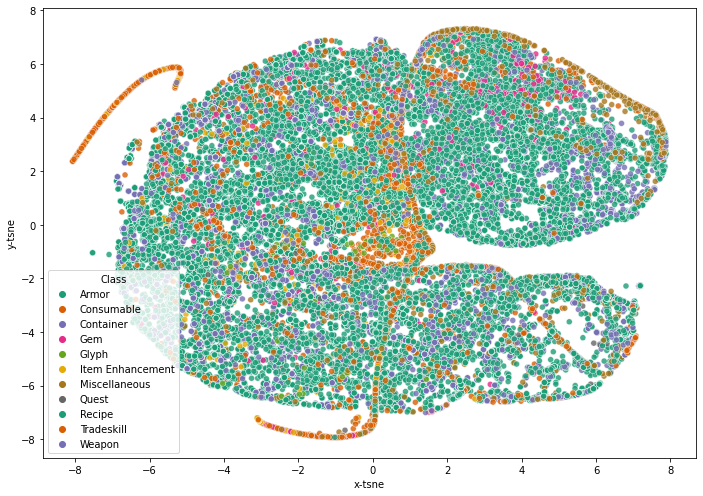

In [23]:
sns.scatterplot(data=df_tsne, x='x-tsne', y='y-tsne',
                alpha=.8,
                palette='Dark2', #palette='viridis',
                hue='Class')

## RegionQuantity vs RegionSaleRate Plot

[None]

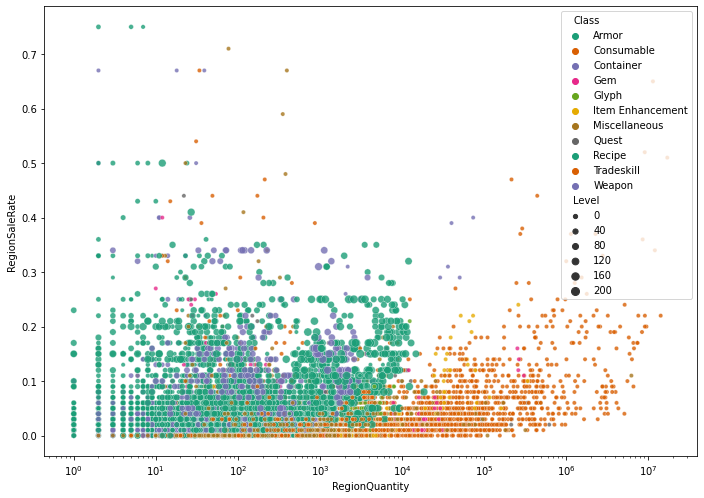

In [24]:
ax = sns.scatterplot(data=dfm_clean, x="RegionQuantity", y="RegionSaleRate",
                    hue="Class", size=dfm_clean.Level,
                    alpha=.8,
                    palette='Dark2', #palette='viridis',
                    legend="brief")
ax.set(xscale="log")

[None]

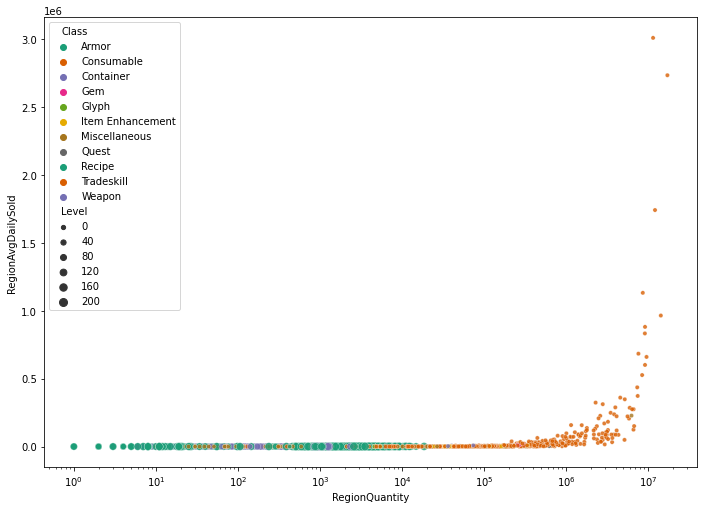

In [25]:
ax = sns.scatterplot(data=dfm_clean, x="RegionQuantity", y="RegionAvgDailySold",
                    hue="Class", size=dfm_clean.Level,
                    alpha=.8,
                    palette='Dark2', #palette='viridis',
                    legend="brief")
ax.set(xscale="log")

## Categorical RegionQuantity

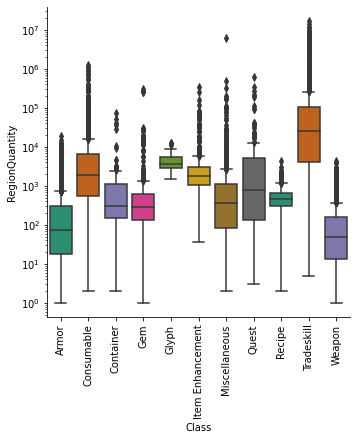

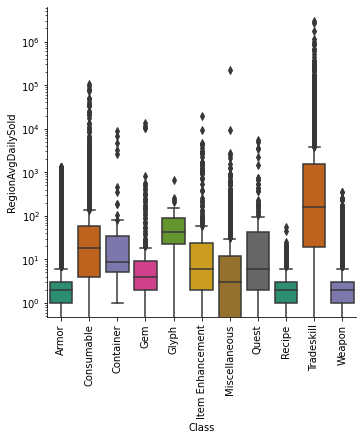

In [26]:
g = sns.catplot(x="Class", y="RegionQuantity", kind="box", data=dfm_clean, palette="Dark2");
g.set_xticklabels(rotation=90)
g.set(yscale="log")

g = sns.catplot(x="Class", y="RegionAvgDailySold", kind="box", data=dfm_clean, palette="Dark2");
g.set_xticklabels(rotation=90)
g.set(yscale="log")

## Calculate Worth

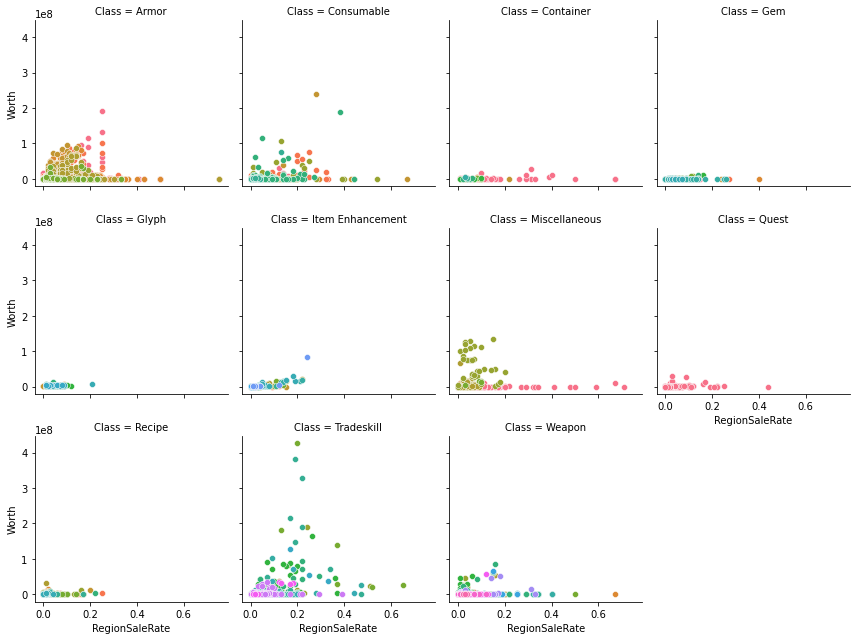

In [27]:
g = sns.FacetGrid(data=dfm_clean, col="Class", col_wrap=4, hue='SubClassId')
g.map(sns.scatterplot, "RegionSaleRate", "Worth", legend="brief")

In [28]:
reduction_strategy = 'B'

In [29]:
if reduction_strategy == 'A':
    list_low = ['Container','Weapon','Armor','Item Enhancements', 'Miscellaneous', 'Recipe']
    list_mid = ['Consumable']
    list_high = ['Tradeskill']

    dfm_relevant = dfm_clean[((dfm_clean['Class'].isin(list_low)) & (dfm_clean['RegionQuantity'] >= 5)) |
                        ((dfm_clean['Class'].isin(list_mid)) & (dfm_clean['RegionQuantity'] >= 10)) |
                        ((dfm_clean['Class'].isin(list_high)) & (dfm_clean['RegionQuantity'] >= 75))]

    
elif reduction_strategy == 'B':
    quantity_cutoff = dfm_clean.RegionQuantity.quantile(1-k_quantity)
    dfm_relevant = dfm_clean[(dfm_clean['RegionQuantity'] >= quantity_cutoff)]

In [30]:
print('Size of new dataset: ', dfm_relevant.shape)
print('Size of old dataset: ', dfm_clean.shape)
print('Used strategy: ', reduction_strategy)
print('Number of remaining items per category: ')
dfm_relevant['Class'].value_counts()

Size of new dataset:  (3647, 31)
Size of old dataset:  (36467, 31)
Used strategy:  B
Number of remaining items per category: 


Tradeskill          1238
Consumable           993
Armor                439
Item Enhancement     330
Miscellaneous        235
Glyph                103
Quest                 91
Weapon                80
Gem                   69
Recipe                42
Container             23
Name: Class, dtype: int64

In [31]:
dfm_relevant['R1'] = dfm_relevant['MarketValue'] / dfm_relevant['RegionMarketAvg']

dfm_relevant[dfm_relevant['ItemId'] == 2880].R1

<ipython-input-31-5dc8b81a1825>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm_relevant['R1'] = dfm_relevant['MarketValue'] / dfm_relevant['RegionMarketAvg']


1062    0.000273
Name: R1, dtype: float64

In [32]:
dfm_scam_safe = dfm_relevant[(dfm_relevant['R1'] >= 0.15) & (dfm_relevant['R1'] <= 3)]
print('Size of new dataset: ', dfm_scam_safe.shape)
dfm_scam_safe['Class'].value_counts()

Size of new dataset:  (2419, 32)


Tradeskill          777
Consumable          499
Armor               416
Item Enhancement    260
Miscellaneous       148
Glyph                99
Weapon               71
Quest                62
Gem                  42
Recipe               24
Container            17
Name: Class, dtype: int64

In [33]:
k_sold

0.05

In [34]:
dfm_most_worthy = dfm_scam_safe.groupby('Class').apply(quantile_function, 1-k_worth, 'Worth')
dfm_most_worthy.Class.value_counts()

dfm_most_sold = dfm_scam_safe.groupby('Class').apply(quantile_function, 1-k_sold, 'RegionAvgDailySold')

dfm_most_sold_and_worthy = pd.merge(
    dfm_most_worthy,
    dfm_most_sold,
    on=('ItemId','Level'),
    suffixes=(None,'_')
)

In [35]:
dfm_most_sold_and_worthy

,RealmId,ItemId,Level,TujMarketValue,Quantity,LastSeen,Name,ItemTypeId,SubClassId,VendorBuy,...,date_tsm_realm_df_,MarketValue_,MinBuyout_,NumAuctions_,Historical_,Class_,SubClass_,Worth_,EstimatedRealmAvgDailySold_,R1_
0,207,171266,0,175.4500,184,2021-03-11 08:54:19,Potion of the Hidden Spirit,0,1,1.0000,...,2021-03-15 07:54:19,166.0151,125.80,19,130.4057,Consumable,Potion,2.246110e+07,151.197047,1.021641
1,207,171267,0,20.9732,3473,2021-03-11 08:54:19,Spiritual Healing Potion,0,1,1.0000,...,2021-03-15 07:54:19,20.0832,18.94,58,19.9348,Consumable,Potion,1.796862e+07,1094.596948,0.819595
2,207,171270,0,190.0000,2866,2021-03-11 08:54:19,Potion of Spectral Agility,0,1,1.0000,...,2021-03-15 07:54:19,225.1889,211.88,13,295.9157,Consumable,Potion,6.858364e+07,234.633544,0.713738
3,207,171273,0,200.0000,1657,2021-03-11 08:54:19,Potion of Spectral Intellect,0,1,1.0000,...,2021-03-15 07:54:19,200.3185,187.00,24,254.0046,Consumable,Potion,7.623809e+07,377.571221,0.734409
4,207,171275,0,130.0000,1454,2021-03-11 08:54:19,Potion of Spectral Strength,0,1,1.0000,...,2021-03-15 07:54:19,146.0979,154.00,17,125.3495,Consumable,Potion,5.108049e+07,250.590423,0.691192
5,207,171276,0,796.9800,1191,2021-03-11 08:54:19,Spectral Flask of Power,0,3,1.0000,...,2021-03-15 07:54:19,824.8598,820.00,46,902.1328,Consumable,Flask,2.394827e+08,421.621196,0.865490
6,207,171278,0,259.9000,629,2021-03-11 08:54:19,Spectral Flask of Stamina,0,3,1.0000,...,2021-03-15 07:54:19,279.9330,230.00,15,331.2943,Consumable,Flask,3.876227e+07,70.794604,0.734618
7,207,171285,0,20.0858,2808,2021-03-11 08:54:19,Shadowcore Oil,0,1,1.0000,...,2021-03-15 07:54:19,19.7208,18.89,23,19.1279,Consumable,Potion,2.395973e+07,1184.315062,0.785145
8,207,171349,0,219.5369,1009,2021-03-11 08:54:19,Potion of Phantom Fire,0,1,1.0000,...,2021-03-15 07:54:19,230.0344,248.79,21,217.8670,Consumable,Potion,5.700956e+07,279.604974,0.777841
9,207,172041,0,80.4900,868,2021-03-11 08:54:19,Spinefin Souffle and Fries,0,5,2.5000,...,2021-03-15 07:54:19,71.2972,67.00,17,98.0236,Consumable,Food & Drink,3.921540e+07,468.727701,0.832784


In [36]:
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None):
    interesting_columns = [
        'Name',
        'Class',
        'SubClass',
        'RegionSaleRate',
        'RegionMarketAvg',
        'RegionAvgDailySold',
        'RegionSaleAvg',
        'EstimatedRealmAvgDailySold',
        'Quantity',
        'RegionQuantity',
        'MarketValue',
        'Worth',
        'RegionStddev',
        'ItemId'
    ]
    the_juice = dfm_most_sold_and_worthy[(dfm_most_sold_and_worthy['RegionSaleRate'] >= 0.1)][interesting_columns]
    
    display_df = pd.DataFrame()
    display_df['Class'] = the_juice['Class']
    display_df['SubClass'] = the_juice['SubClass']
    display_df['Name'] = the_juice['Name']
    display_df['Quantity'] = the_juice['Quantity'].map('{:20,.2f}'.format)
    display_df['RegionQuantity'] = the_juice['RegionQuantity'].map('{:20,.2f}'.format)
    display_df['RegionSaleRate'] = the_juice['RegionSaleRate'].map('{:0.2f}'.format)
    display_df['Worth'] = the_juice['Worth'].map('{:20,.2f}G'.format)
    display_df['EstimatedRealmDailySold'] = the_juice['EstimatedRealmAvgDailySold'].map('{:20,.0f}'.format)
    display_df['RegionAvgDailySold'] = the_juice['RegionAvgDailySold'].map('{:20,.0f}'.format)
    display_df['AvgPostingsToSell'] = (1 / the_juice['RegionSaleRate']).map('{:0.2f}'.format)
    display_df['MarketValue'] = the_juice['MarketValue'].map('{:20,.2f}G'.format)
    display_df['RegionMarketAvg'] = the_juice['RegionMarketAvg'].map('{:20,.2f}G'.format)
    display_df['StdDev'] = the_juice['RegionStddev'].map('{:20,.2f}G'.format)
    
    display_df = display_df.set_index(['Class','SubClass'])
    display(
        display_df
    )

Name  \
Class            SubClass                                                     
Consumable       Potion                         Potion of the Hidden Spirit   
                 Potion                            Spiritual Healing Potion   
                 Potion                          Potion of Spectral Agility   
                 Potion                        Potion of Spectral Intellect   
                 Potion                         Potion of Spectral Strength   
                 Flask                              Spectral Flask of Power   
                 Flask                            Spectral Flask of Stamina   
                 Potion                                      Shadowcore Oil   
                 Potion                              Potion of Phantom Fire   
                 Food & Drink                    Spinefin Souffle and Fries   
                 Food & Drink                   Tenebrous Crown Roast Aspic   
                 Food & Drink           Iridescent Ravioli with Apple Sauce   
                 Other                            Drums of Deathly Ferocity   
                 Other                               Tome of the Still Mind   
                 Other                                  Veiled Augment Rune   
Gem              Critical Strike                       Deadly Jewel Cluster   
                 Haste                                  Quick Jewel Cluster   
                 Versatility                        Versatile Jewel Cluster   
Glyph            Druid                                       Glyph of Stars   
Item Enhancement Misc                              Heavy Desolate Armor Kit   
                 Finger             Enchant Ring - Tenet of Critical Strike   
                 Finger                       Enchant Ring - Tenet of Haste   
                 Finger                 Enchant Ring - Tenet of Versatility   
                 One-handed weapon      Enchant Weapon - Celestial Guidance   
                 One-handed weapon       Enchant Weapon - Sinful Revelation   
                 Chest                        Enchant Chest - Eternal Stats   
Tradeskill       Metal & Stone                               Ghost Iron Ore   
                 Herb                                            Widowbloom   
                 Herb                                          Rising Glory   
                 Herb                                            Marrowroot   
                 Herb                                         Death Blossom   
                 Herb                                         Vigil's Torch   
                 Herb                                            Nightshade   
                 Metal & Stone                                Laestrite Ore   
                 Metal & Stone                                 Solenium Ore   
                 Metal & Stone                                   Oxxein Ore   
                 Metal & Stone                                 Phaedrum Ore   
                 Metal & Stone                                   Sinvyr Ore   
                 Metal & Stone                                 Elethium Ore   
                 Cooking                                     Tenebrous Ribs   
                 Leather                                       Callous Hide   
                 Enchanting                                       Soul Dust   
                 Cooking                               Iridescent Amberjack   
                 Cloth                                       Lightless Silk   
Weapon           Two-Handed Swords                     Ceremonious Claymore   
                 Staves                                 Soul Keeper's Spire   

                                                Quantity  \
Class            SubClass                                  
Consumable       Potion                           184.00   
                 Potion                         3,473.00   
                 Potion               

count    4.600000e+01
mean     1.980409e+05
std      3.370526e+05
min      2.250000e+02
25%      1.117550e+04
50%      3.961600e+04
75%      2.829785e+05
max      1.742228e+06
Name: RegionAvgDailySold, dtype: float64

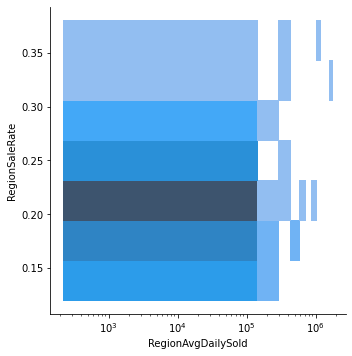

In [37]:
display(the_juice.RegionAvgDailySold.describe())
g = sns.displot(the_juice, x='RegionAvgDailySold', y='RegionSaleRate')
g.set(xscale="log")

[None]

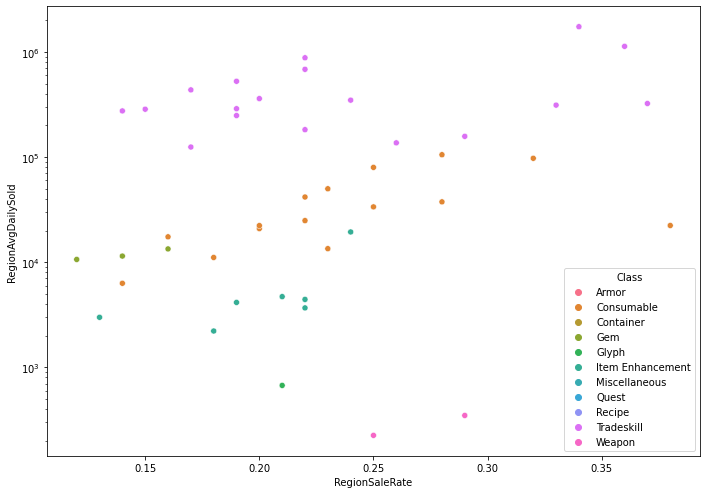

In [38]:
g = sns.scatterplot(data=the_juice, x='RegionSaleRate', y='RegionAvgDailySold', hue='Class')
g.set(yscale="log")

In [39]:
','.join(the_juice.ItemId.map('i:{}'.format))

'i:171266,i:171267,i:171270,i:171273,i:171275,i:171276,i:171278,i:171285,i:171349,i:172041,i:172045,i:172049,i:172233,i:173049,i:181468,i:173127,i:173128,i:173129,i:44922,i:172347,i:172361,i:172362,i:172364,i:172366,i:172368,i:177962,i:72092,i:168583,i:168586,i:168589,i:169701,i:170554,i:171315,i:171828,i:171829,i:171830,i:171831,i:171832,i:171833,i:172053,i:172094,i:172230,i:173033,i:173204,i:171383,i:173054'

In [40]:
display_df

Name  \
Class            SubClass                                                     
Consumable       Potion                         Potion of the Hidden Spirit   
                 Potion                            Spiritual Healing Potion   
                 Potion                          Potion of Spectral Agility   
                 Potion                        Potion of Spectral Intellect   
                 Potion                         Potion of Spectral Strength   
                 Flask                              Spectral Flask of Power   
                 Flask                            Spectral Flask of Stamina   
                 Potion                                      Shadowcore Oil   
                 Potion                              Potion of Phantom Fire   
                 Food & Drink                    Spinefin Souffle and Fries   
                 Food & Drink                   Tenebrous Crown Roast Aspic   
                 Food & Drink           Iridescent Ravioli with Apple Sauce   
                 Other                            Drums of Deathly Ferocity   
                 Other                               Tome of the Still Mind   
                 Other                                  Veiled Augment Rune   
Gem              Critical Strike                       Deadly Jewel Cluster   
                 Haste                                  Quick Jewel Cluster   
                 Versatility                        Versatile Jewel Cluster   
Glyph            Druid                                       Glyph of Stars   
Item Enhancement Misc                              Heavy Desolate Armor Kit   
                 Finger             Enchant Ring - Tenet of Critical Strike   
                 Finger                       Enchant Ring - Tenet of Haste   
                 Finger                 Enchant Ring - Tenet of Versatility   
                 One-handed weapon      Enchant Weapon - Celestial Guidance   
                 One-handed weapon       Enchant Weapon - Sinful Revelation   
                 Chest                        Enchant Chest - Eternal Stats   
Tradeskill       Metal & Stone                               Ghost Iron Ore   
                 Herb                                            Widowbloom   
                 Herb                                          Rising Glory   
                 Herb                                            Marrowroot   
                 Herb                                         Death Blossom   
                 Herb                                         Vigil's Torch   
                 Herb                                            Nightshade   
                 Metal & Stone                                Laestrite Ore   
                 Metal & Stone                                 Solenium Ore   
                 Metal & Stone                                   Oxxein Ore   
                 Metal & Stone                                 Phaedrum Ore   
                 Metal & Stone                                   Sinvyr Ore   
                 Metal & Stone                                 Elethium Ore   
                 Cooking                                     Tenebrous Ribs   
                 Leather                                       Callous Hide   
                 Enchanting                                       Soul Dust   
                 Cooking                               Iridescent Amberjack   
                 Cloth                                       Lightless Silk   
Weapon           Two-Handed Swords                     Ceremonious Claymore   
                 Staves                                 Soul Keeper's Spire   

                                                Quantity  \
Class            SubClass                                  
Consumable       Potion                           184.00   
                 Potion                         3,473.00   
                 Potion               

In [41]:
the_juice.EstimatedRealmAvgDailySold.map(lambda x: sp.stats.percentileofscore(the_juice.EstimatedRealmAvgDailySold, x))

0      32.608696
1      58.695652
2      39.130435
3      47.826087
4      41.304348
5      50.000000
6      21.739130
7      60.869565
8      45.652174
9      52.173913
10     56.521739
11     54.347826
12     26.086957
13     34.782609
14     43.478261
15     23.913043
16     30.434783
17     28.260870
18      6.521739
19     36.956522
20     10.869565
21     19.565217
22     17.391304
23     15.217391
24      8.695652
25     13.043478
26     63.043478
28     91.304348
29     93.478261
30     95.652174
31    100.000000
32     89.130435
33     71.739130
34     97.826087
35     76.086957
36     73.913043
37     86.956522
38     78.260870
39     65.217391
40     67.391304
41     82.608696
42     80.434783
43     69.565217
44     84.782609
45      4.347826
46      2.173913
Name: EstimatedRealmAvgDailySold, dtype: float64

In [42]:
for i in range(10,100,5):
    print(i, the_juice.EstimatedRealmAvgDailySold.quantile(i/100))

10 37.442479371779086
15 48.90446285293596
20 70.79460385420417
25 125.58176117026328
30 150.7531758739803
35 212.42876051744054
40 250.59042316646872
45 304.0965352699279
50 445.174448617167
55 813.1659231751921
60 1184.3150618098864
65 1594.8731965900893
70 2421.7878813233124
75 3179.896953453478
80 3509.8953239430793
85 3948.0240238909473
90 5410.48883679626
95 9352.057067050027


In [43]:
the_juice['Potential'] = the_juice['RegionAvgDailySold'] * the_juice['RegionSaleAvg']
the_juice['ControlFactor'] = (the_juice['Quantity'] * the_juice['MarketValue']) * 0.66

In [44]:
the_juice[the_juice['Class'] == 'Tradeskill'][['Name', 'Quantity', 'Potential', 'ControlFactor']].sort_values(by='ControlFactor')

,Name,Quantity,Potential,ControlFactor
37,Phaedrum Ore,1073,6.231496e+06,2.331683e+04
42,Soul Dust,2995,4.300678e+06,3.602773e+04
26,Ghost Iron Ore,6267,1.047419e+06,3.975983e+04
31,Death Blossom,9347,1.032967e+07,5.632747e+04
38,Sinvyr Ore,10539,4.873696e+06,1.215641e+05
34,Laestrite Ore,37955,5.970777e+06,1.352917e+05
43,Iridescent Amberjack,14650,5.374896e+06,1.961995e+05
36,Oxxein Ore,34869,3.706116e+06,3.096012e+05
41,Callous Hide,7066,1.972647e+07,3.293024e+05
35,Solenium Ore,40352,3.886102e+06,3.313087e+05


In [45]:
the_juice[the_juice['Class'] == 'Tradeskill']['ControlFactor'].sum()

8061737.383458